In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as nnf
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import truncnorm
from scipy.sparse import spdiags

%matplotlib notebook

torch.set_default_dtype(torch.float64)

In [2]:
use_gpu = torch.cuda.is_available()

In [3]:
print(use_gpu)

True


In [4]:
def is_array(X):
    return isinstance(X, (list, tuple, np.ndarray))

In [5]:
class FourierFunction:
    
    def __init__(self, degree):
        self.degree = degree
        self.K = torch.tensor([i for i in range(self.degree)], dtype=torch.float64)
        
        lim = 10
        sigma = 0.1
        a, b = -lim/sigma, +lim/sigma 
        self.A = torch.from_numpy(sigma * truncnorm.rvs(a, b, size=self.degree))
        self.B = torch.from_numpy(sigma * truncnorm.rvs(a, b, size=self.degree))
        
    def basis_cos(self, x):
        if is_array(x):
            return np.cos(np.outer(self.K, x))
    
        if torch.is_tensor(x):
            return torch.cos(torch.ger(self.K, x))
    
        return np.cos(x * self.K)
    
    def basis_sin(self, x):
        if is_array(x):
            return np.sin(np.outer(self.K, x))
    
        if torch.is_tensor(x):
            return torch.sin(torch.ger(self.K, x))
    
        return np.sin(x * K)
    
    def compute(self, X):
        return (self.A @ self.basis_cos(X)) + (self.B @ self.basis_sin(X))
    
    def derive1(self, X):
        return ((self.B * self.K) @ self.basis_cos(X)) - ((self.A * self.K) @ self.basis_sin(X))
    
    def derive2(self, X):
        return -((self.A * (self.K**2)) @ self.basis_cos(X)) - ((self.B * (self.K**2)) @ self.basis_sin(X))
    
    def derive3(self, X):
        return -((self.B * (self.K**3)) @ self.basis_cos(X)) + ((self.A * (self.K**3)) @ self.basis_sin(X))
    
    def derive4(self, X):
        return ((self.A * (self.K**4)) @ self.basis_cos(X)) + ((self.B * (self.K**4)) @ self.basis_sin(X))

In [6]:
def generate_coefficients():
    lim = 10
    sigma = 0.1
    a, b = -lim/sigma, +lim/sigma 
    A = sigma * truncnorm.rvs(a, b, size=degree)
    B = sigma * truncnorm.rvs(a, b, size=degree)
    return torch.from_numpy(A), torch.from_numpy(B)

In [7]:
X = torch.linspace(0, 1, 1000)

In [8]:
# Gotta initialize the weights properly
delta = 1/1001
J = np.ones([1000])

# the 1st derivative
diags1 = np.array([-1,0,1])
down1 = -0.5*J*(delta**(-1))
down1[998] = -1/delta
dia1 = np.zeros([1000])
dia1[0] = -1/delta
dia1[999] = 1/delta
up1 = 0.5*J*(delta**(-1))
up1[1] = 1/delta
vecs1 = np.array([down1, dia1, up1])
wei1 = spdiags(vecs1, diags1, 1000, 1000).toarray()

# the 2nd derivative
diags2 = np.array([-2,-1,0,1,2])
down2 = J*(delta**(-2))
down2[998] = -2*(delta**(-2))
ddown2 = np.zeros([1000])
ddown2[997] = delta**(-2)
dia2 = -2*J*(delta**(-2))
dia2[0] = delta**(-2)
dia2[999] = delta**(-2)
up2 = J*(delta**(-2))
up2[1] = -2*(delta**(-2))
uup2 = np.zeros([1000])
uup2[2] = delta**(-2)
vecs2 = np.array([ddown2, down2, dia2, up2, uup2])
wei2 = spdiags(vecs2, diags2, 1000, 1000).toarray()

# the 3rd derivative
diags3 = np.array([-3,-2,-1,0,1,2,3])
dddown3 = np.zeros([1000])
dddown3[996] = -delta**(-3)
ddown3 = -0.5*J*(delta**(-3))
ddown3[996] = -delta**(-3)
ddown3[997] = 3*(delta**(-3))
down3 = J*(delta**(-3))
down3[0] = -delta**(-3)
down3[997] = +3*(delta**(-3))
down3[998] = -3*(delta**(-3))
dia3 = np.zeros([1000])
dia3[0] = -delta**(-3)
dia3[1] = 3*(delta**(-3))
dia3[998] = -3*(delta**(-3))
dia3[999] = delta**(-3)
up3 = -J*(delta**(-3))
up3[1] = 3*(delta**(-3))
up3[2] = -3*(delta**(-3))
up3[999] = delta**(-3)
uup3 = 0.5*J*(delta**(-3))
uup3[2] = -3*(delta**(-3))
uup3[3] = delta**(-3)
uuup3 = np.zeros([1000])
uuup3[3] = delta**(-3)
vecs3 = np.array([dddown3,ddown3,down3,dia3,up3,uup3,uuup3])
wei3 = spdiags(vecs3, diags3, 1000, 1000).toarray()

wei = np.concatenate((wei1, wei2, wei3), axis=0)
weig = torch.from_numpy(wei)

In [10]:
class DerivativeNet(nn.Module):

    def __init__(self):
        super(DerivativeNet, self).__init__()
        self.direct = nn.Linear(1000, 3000)
        with torch.no_grad():
            self.direct.weight.copy_(weig)
        nn.init.zeros_(self.direct.bias)
        self.nonlin = nn.Tanh()
        self.fct1 = nn.Linear(1000, 1000)
        nn.init.zeros_(self.fct1.weight)
        nn.init.zeros_(self.fct1.bias)
        self.fct2 = nn.Linear(1000, 3000)
        nn.init.zeros_(self.fct2.weight)
        nn.init.zeros_(self.fct2.bias)

    def forward(self, x):
        x = self.direct(x) + self.fct2(self.nonlin(self.fct1(x)))
        return x

In [11]:
net = DerivativeNet()
if use_gpu:
    net = net.cuda()
net.load_state_dict(torch.load('saves/modela'))
criterion = nn.MSELoss()
optimizer = optim.RMSprop(net.parameters(), lr=0.00005)
batch_size = 20

Epoch 0: 418043.630126 Degree 79


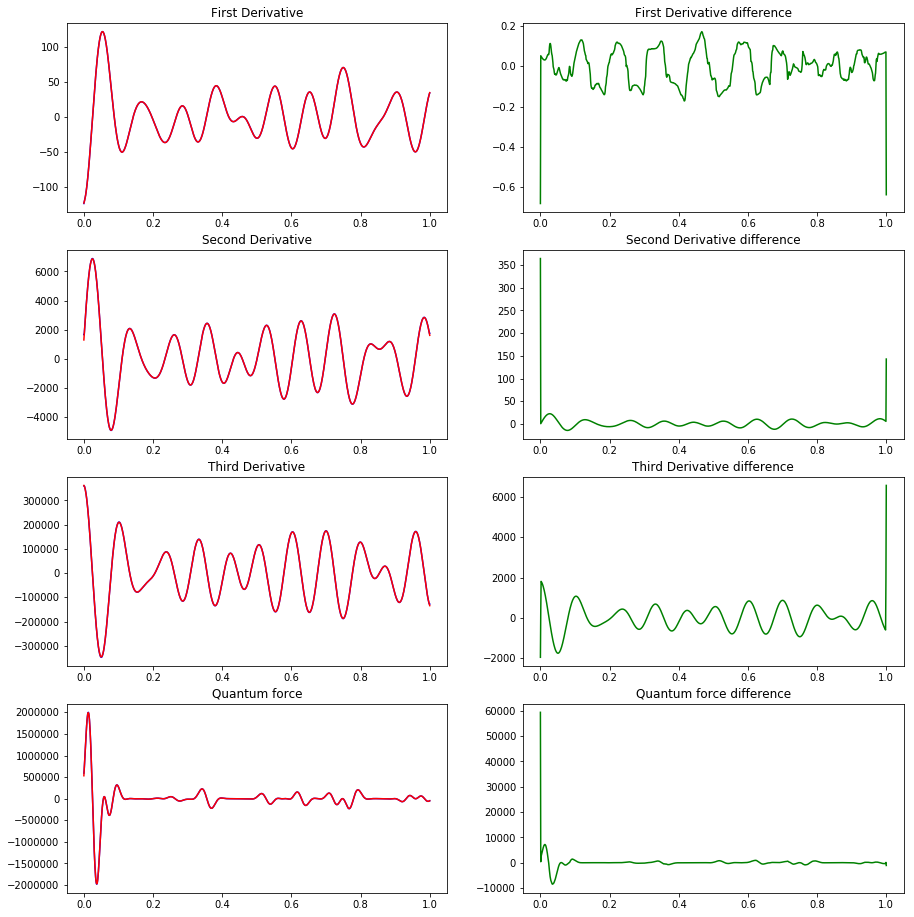

Epoch 1000: 289940.119153 Degree 11


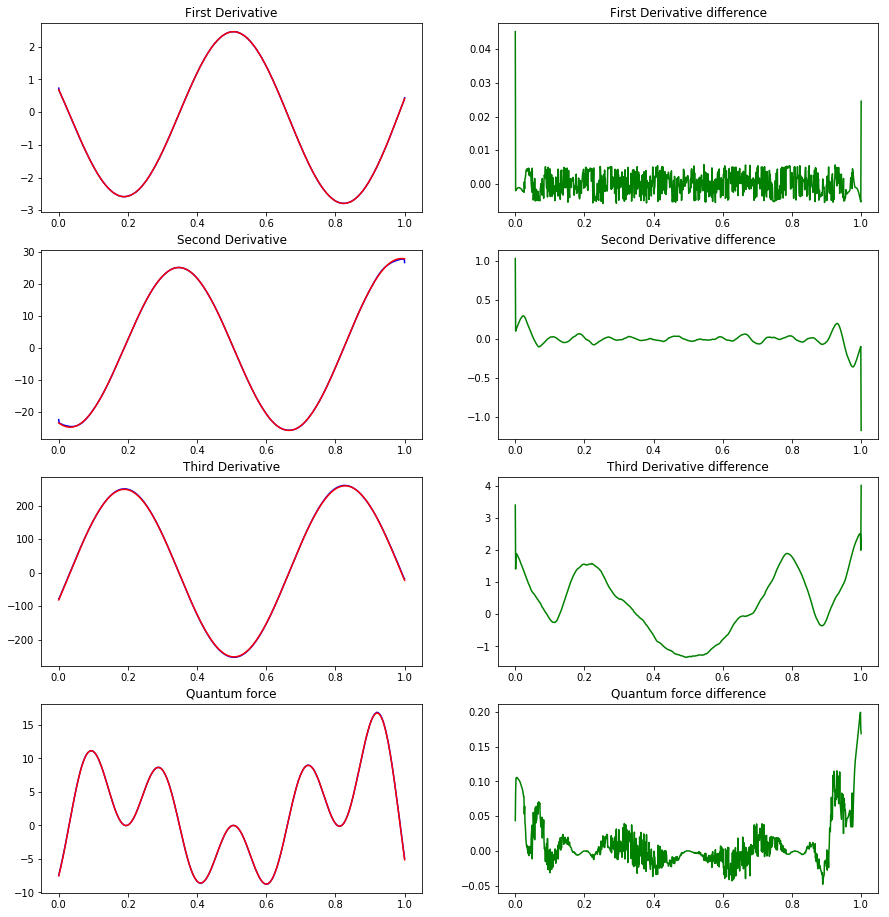

Epoch 2000: 486650.045320 Degree 80


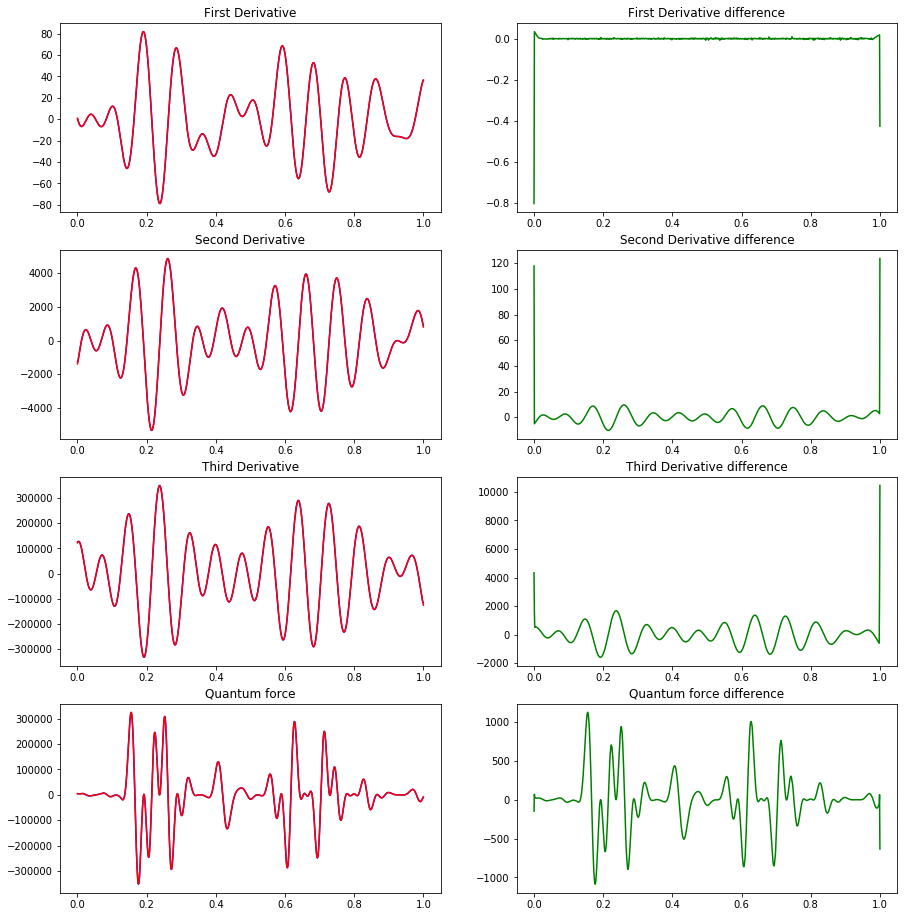

Epoch 3000: 575277.299773 Degree 12


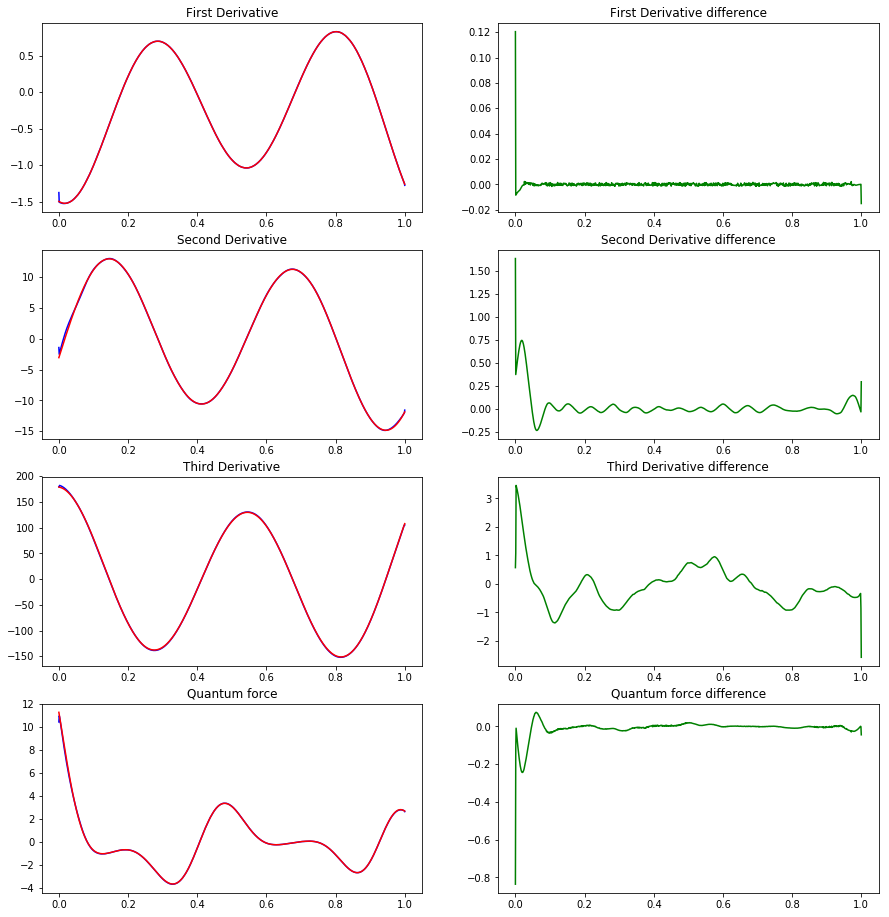

Epoch 4000: 192397.384305 Degree 21


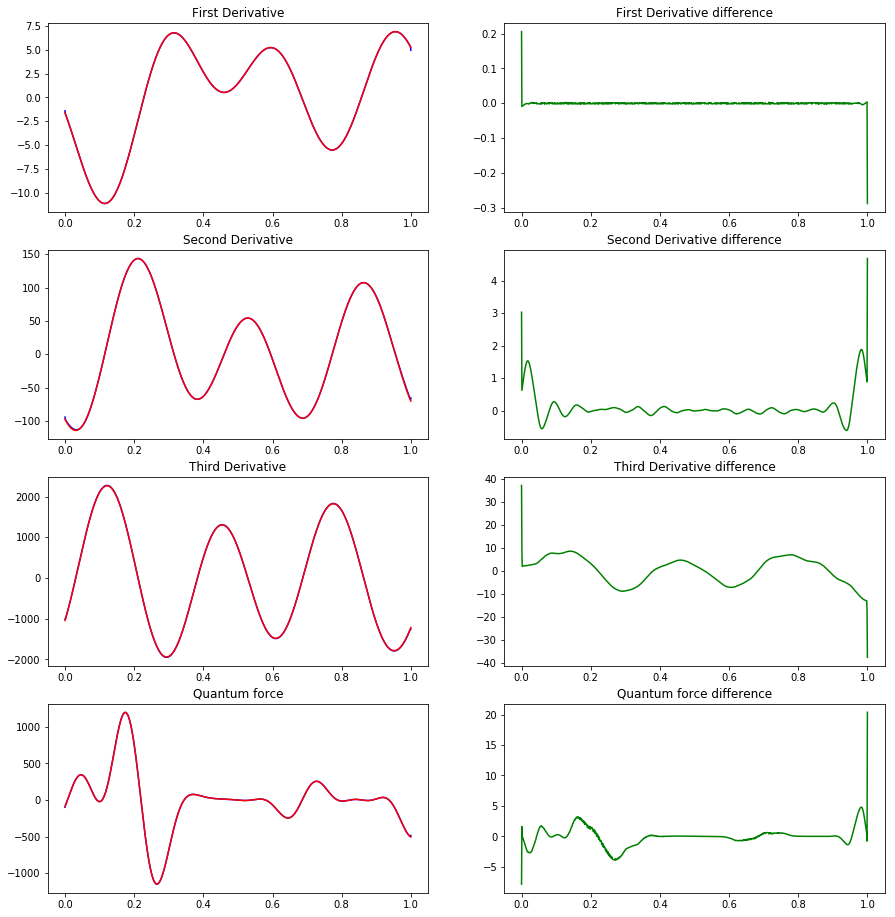

Epoch 5000: 437891.789549 Degree 15


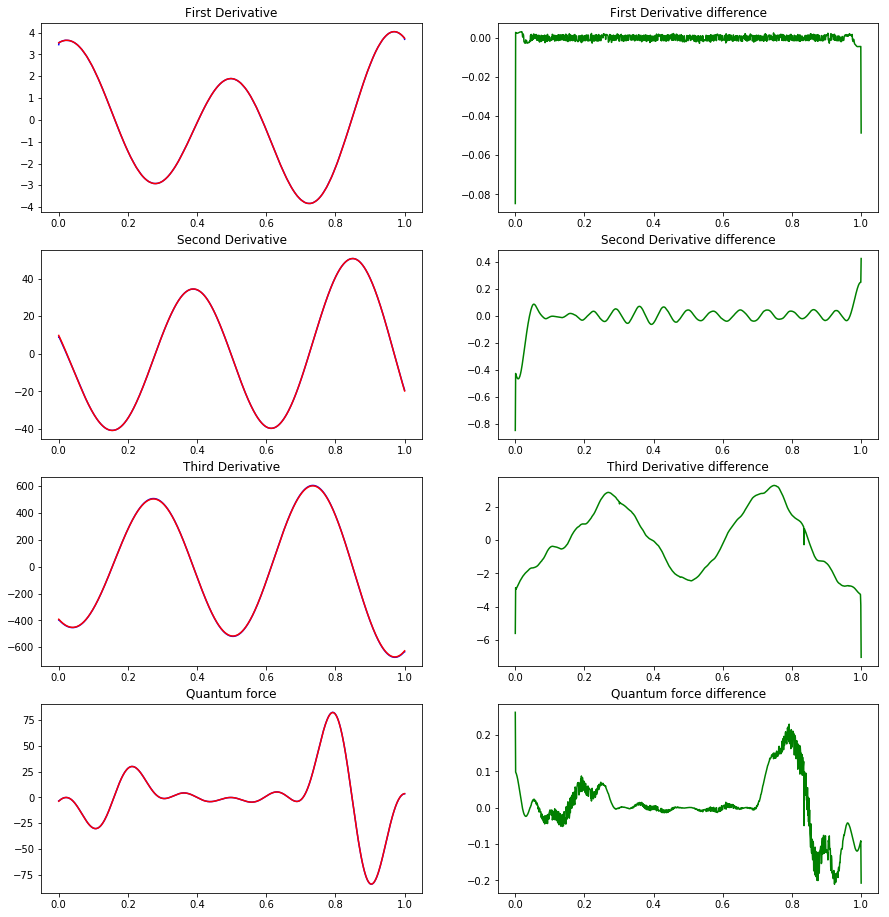

Epoch 6000: 740484.764423 Degree 25


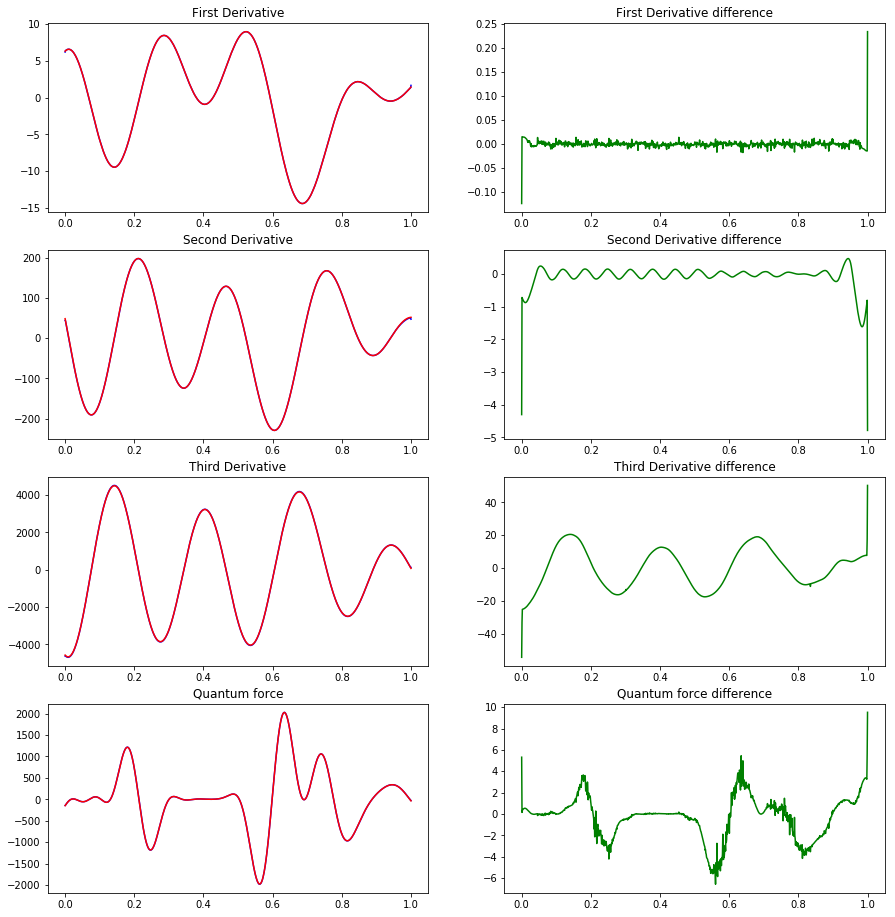

Epoch 7000: 377853.995967 Degree 38


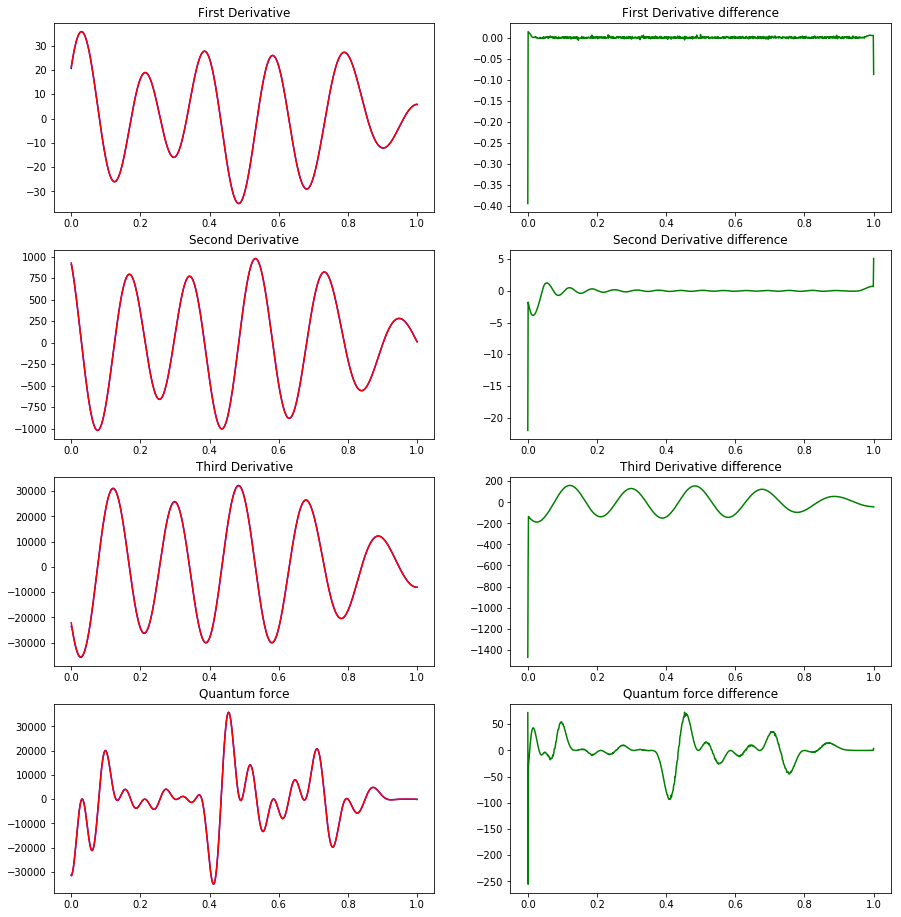

Epoch 8000: 348696.037001 Degree 62


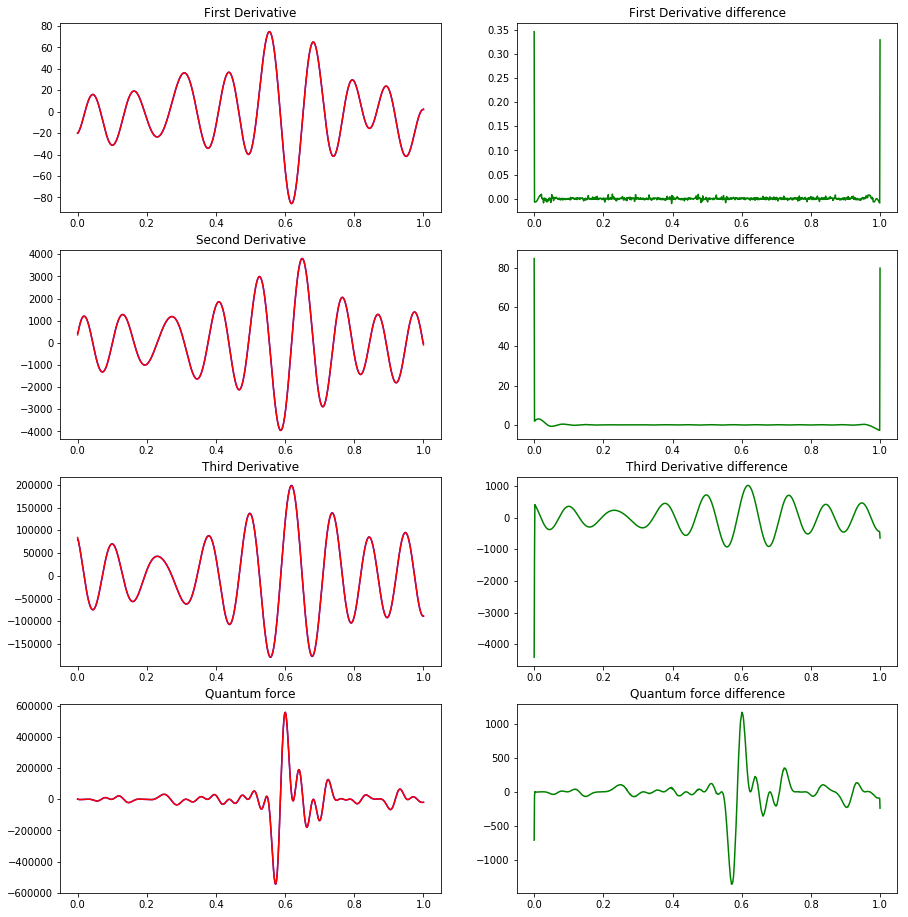

Epoch 9000: 103777.980266 Degree 42


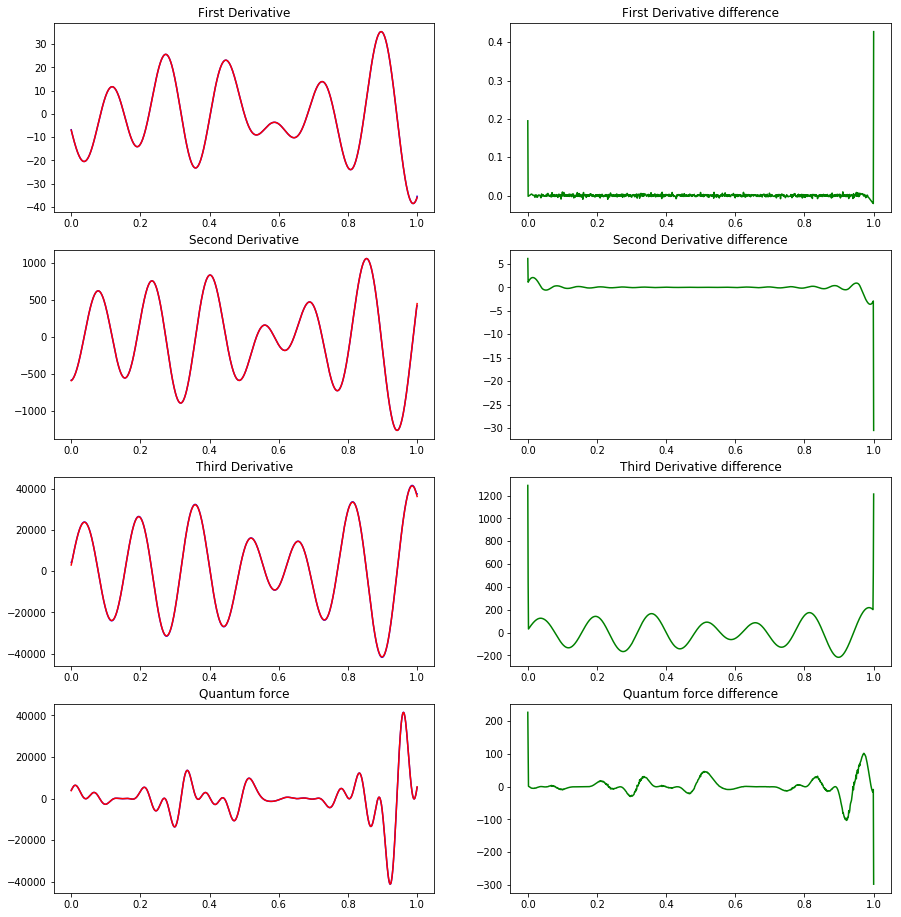

Epoch 10000: 117708.707404 Degree 12


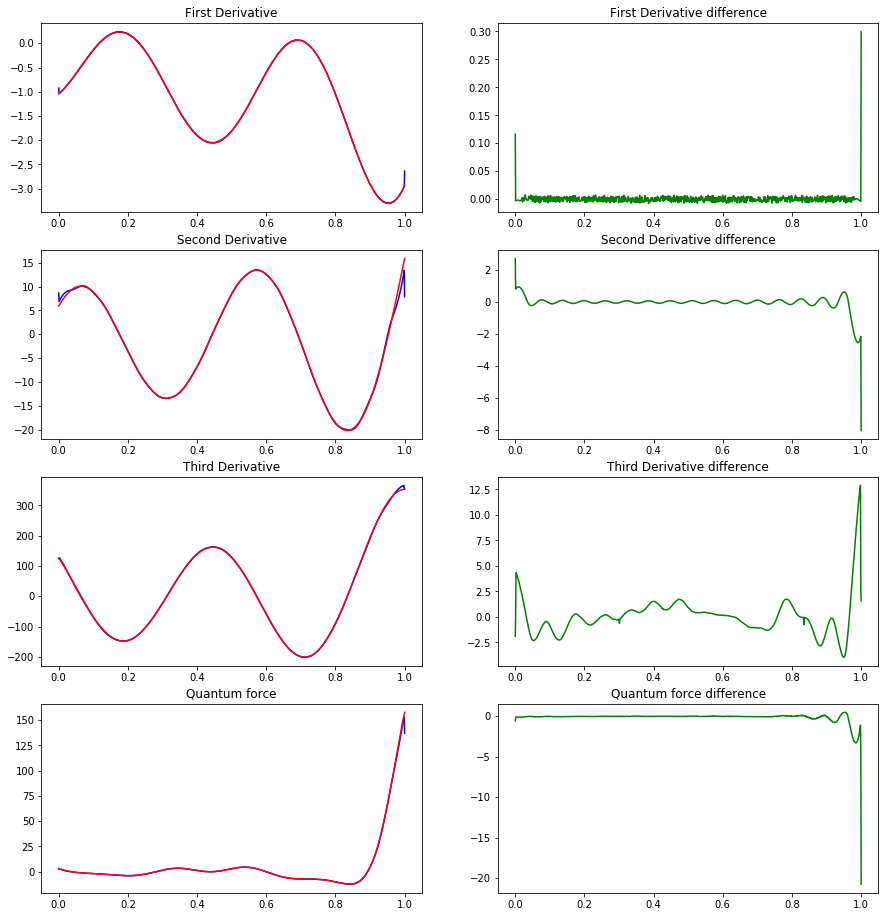

Epoch 11000: 279864.874609 Degree 98


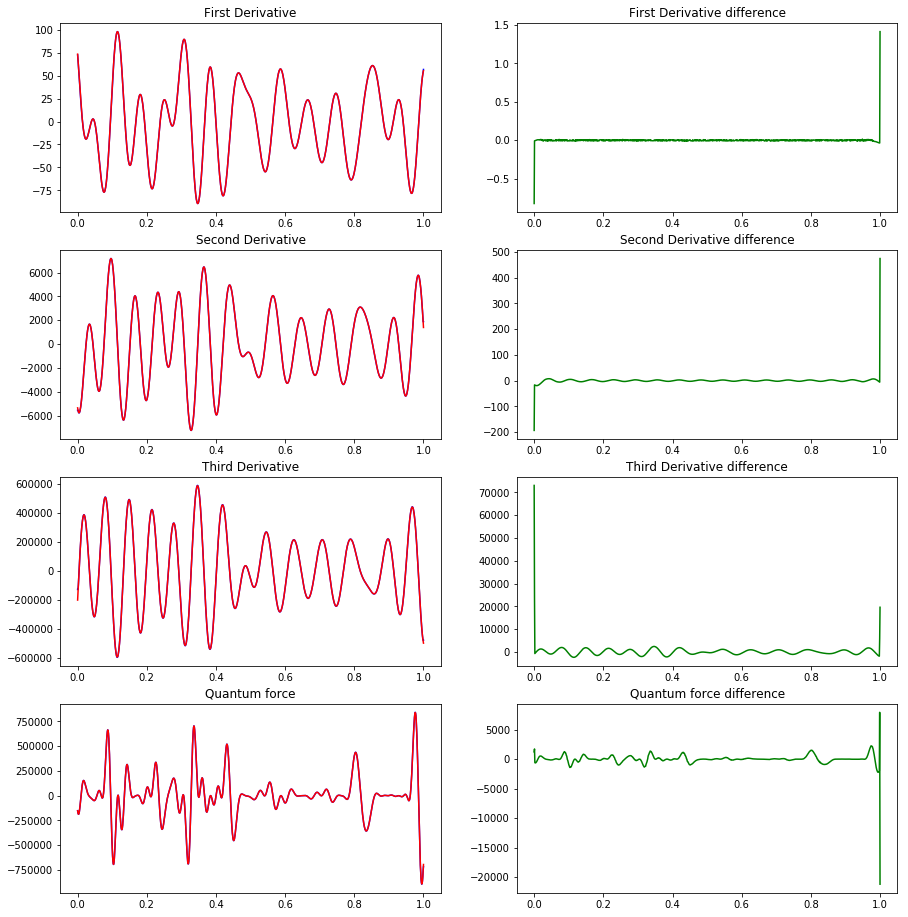

Epoch 12000: 413847.997947 Degree 76


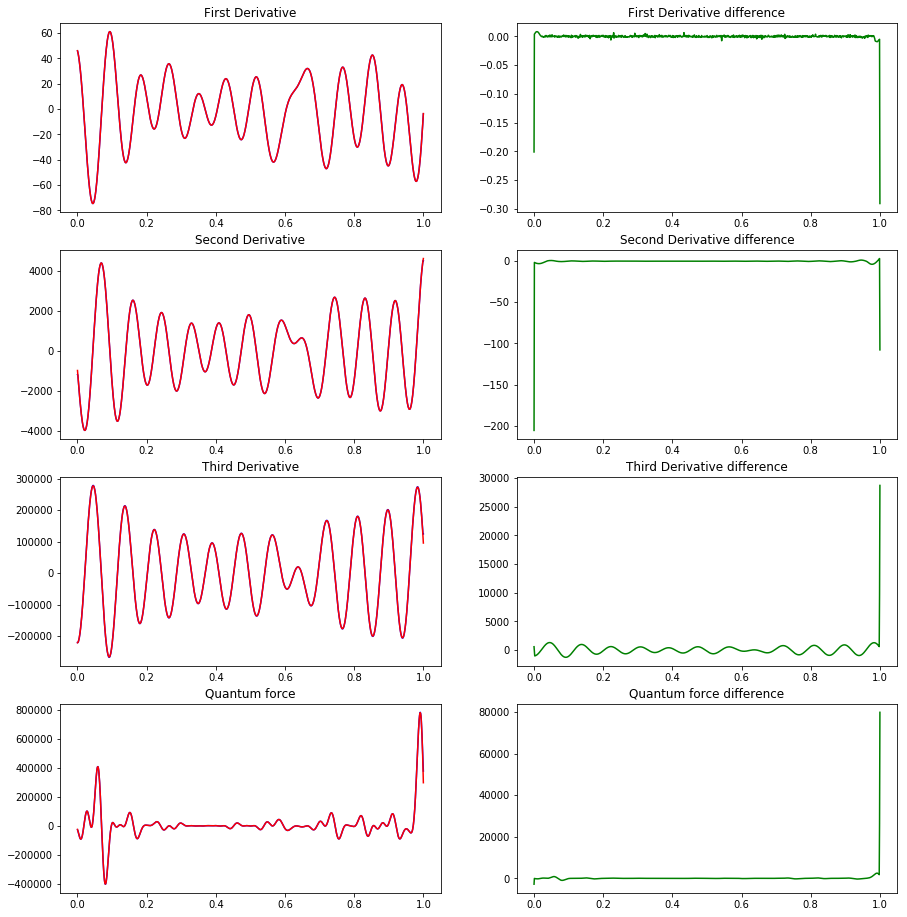

Epoch 13000: 166474.572340 Degree 66


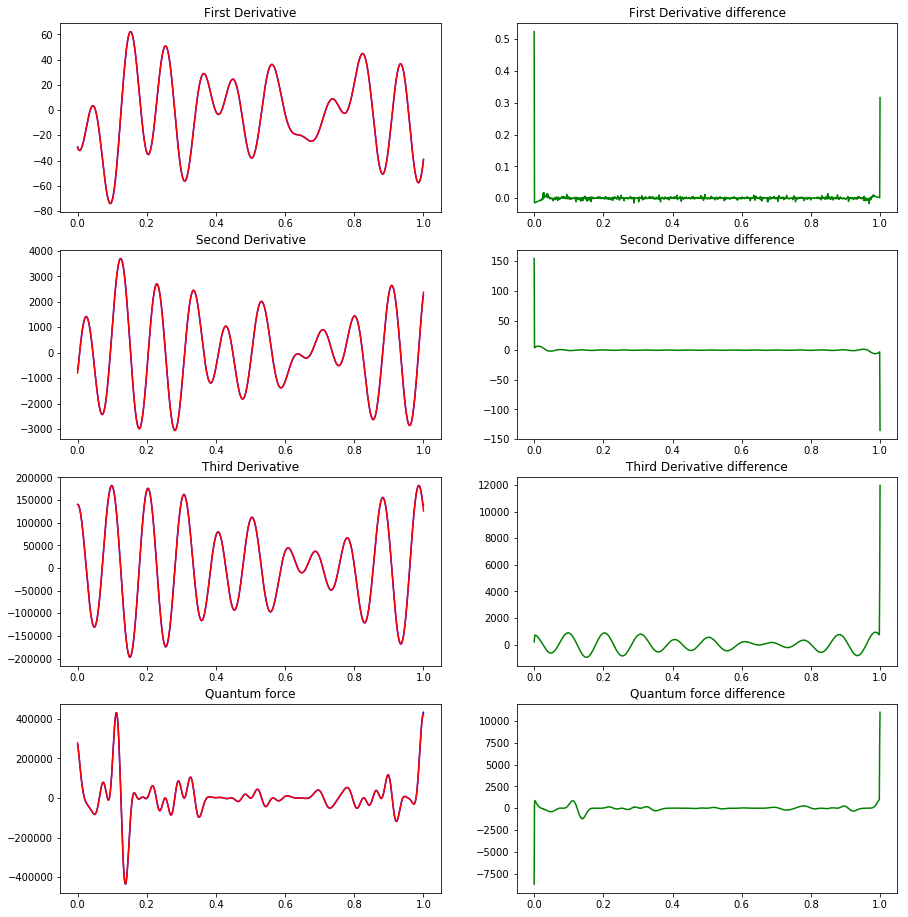

Epoch 14000: 97864.635214 Degree 11


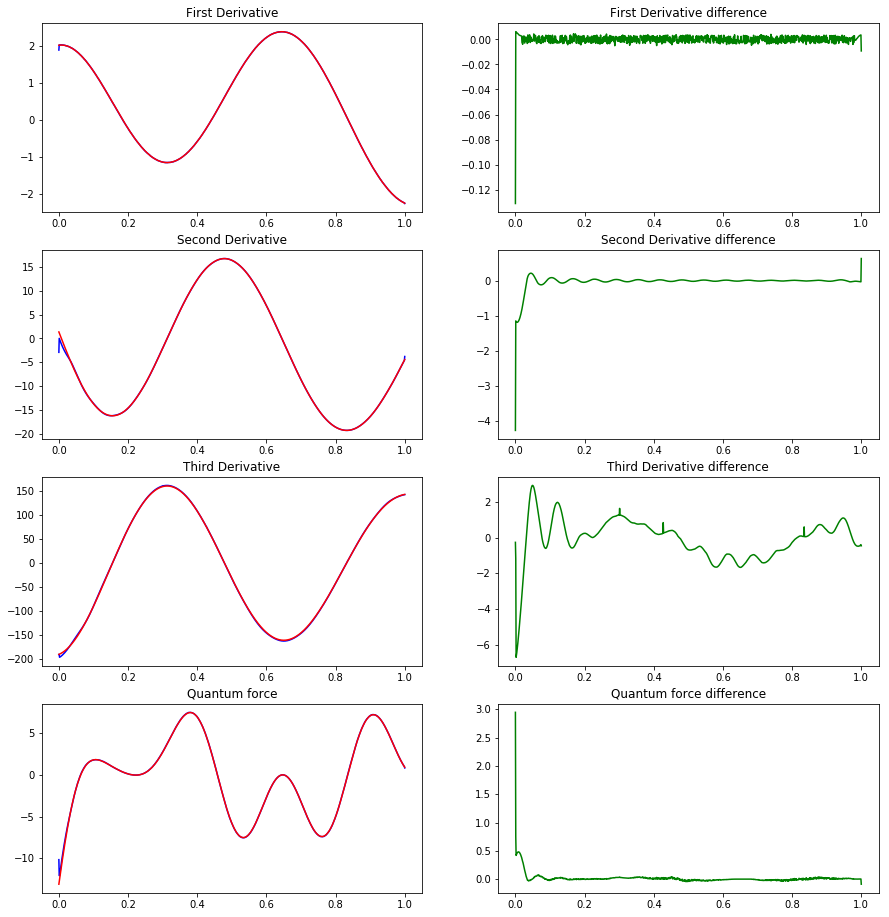

Epoch 15000: 172276.379293 Degree 24


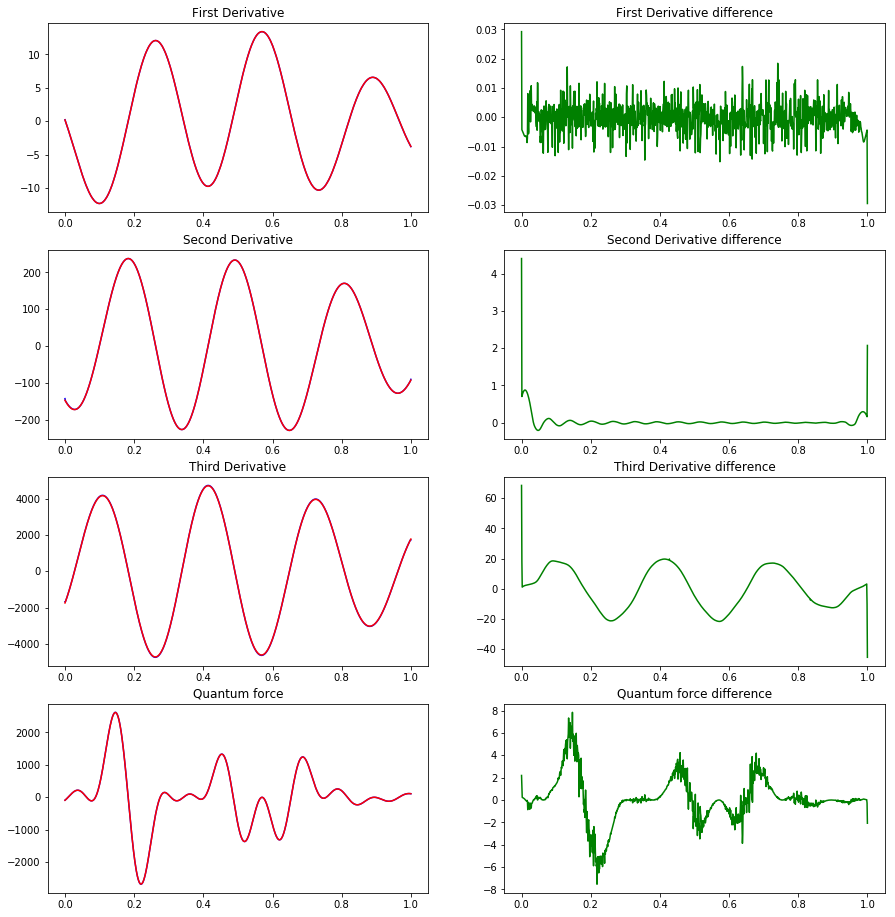

Epoch 16000: 193632.036914 Degree 100


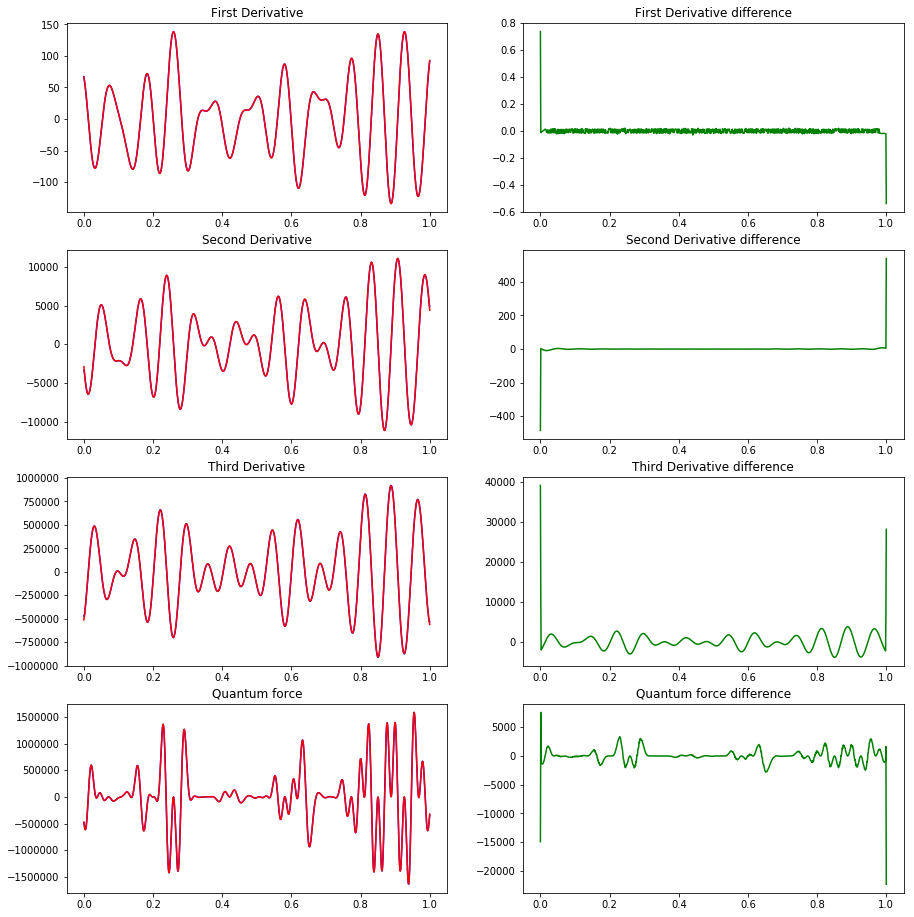

Epoch 17000: 183471.818403 Degree 89


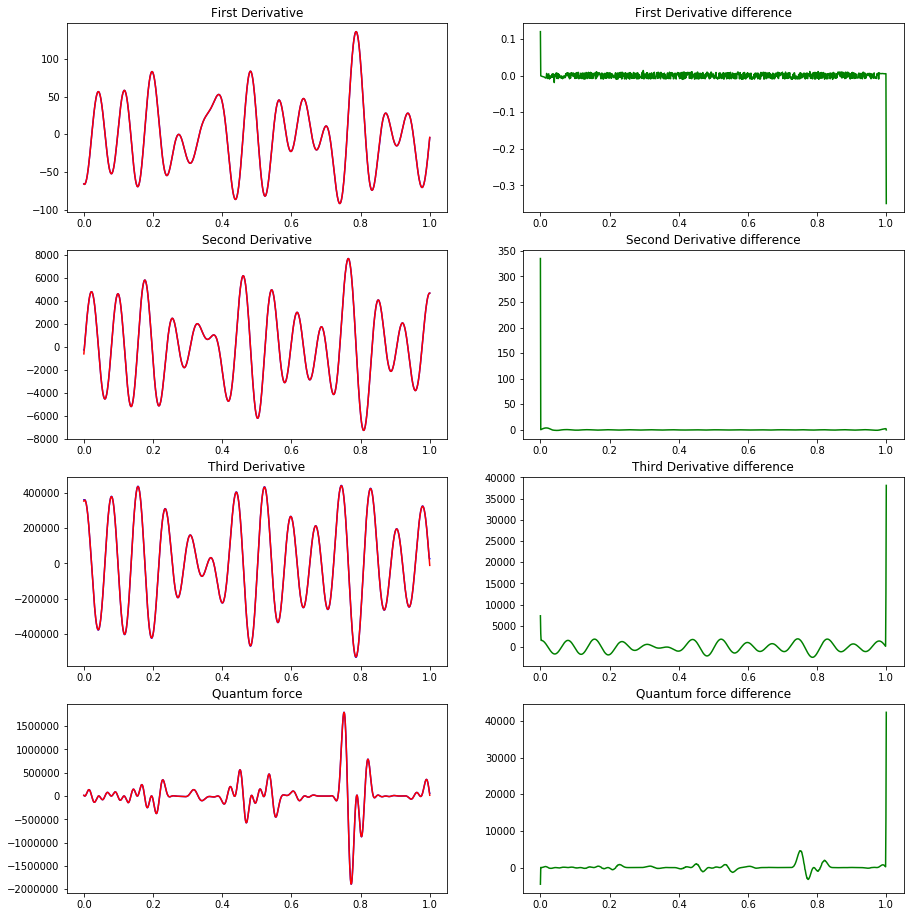

Epoch 18000: 270334.444150 Degree 89


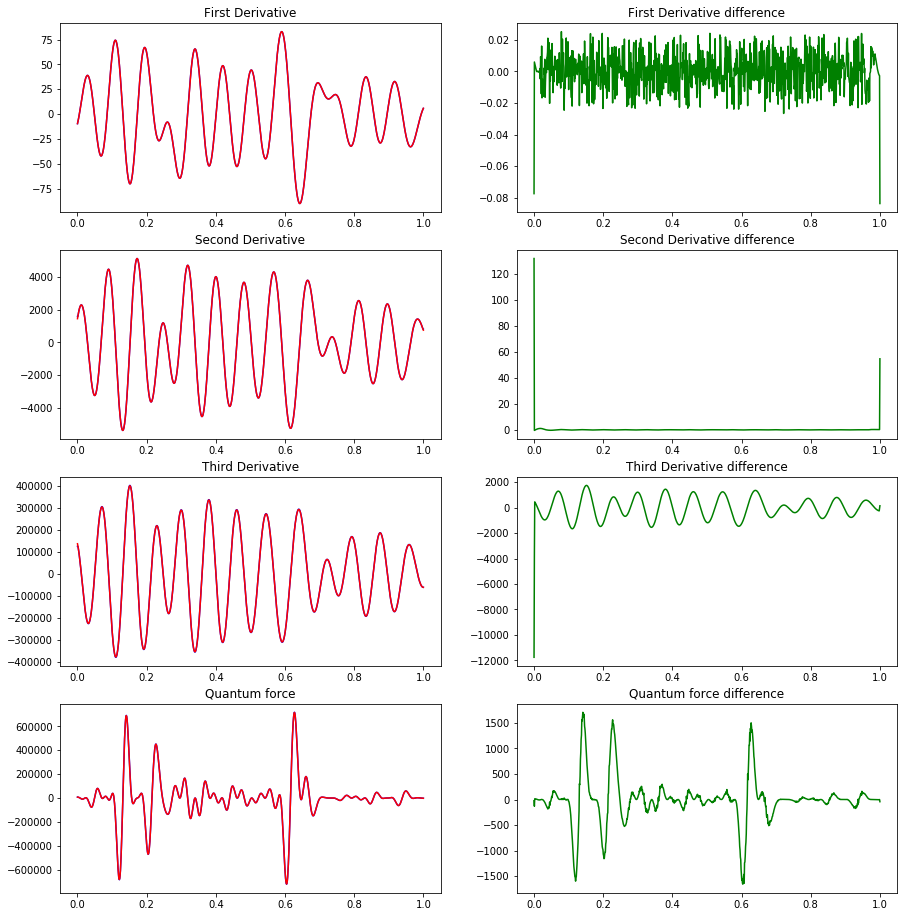

Epoch 19000: 332225.254080 Degree 79


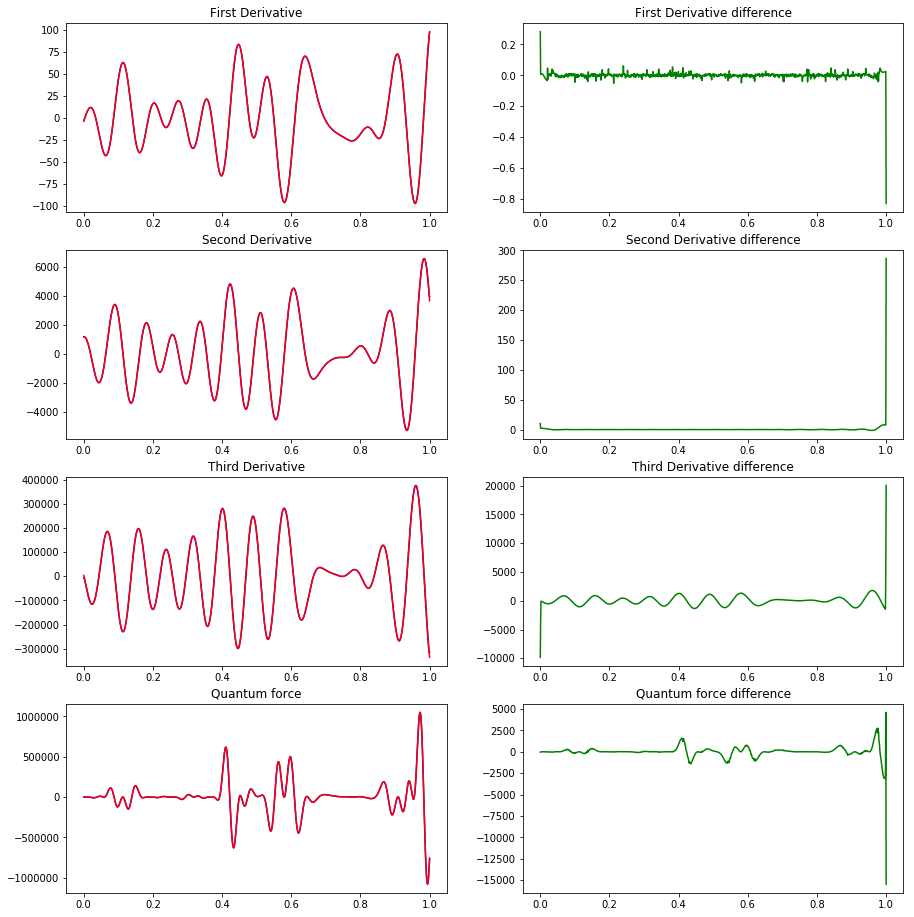

Epoch 20000: 504385.834130 Degree 1


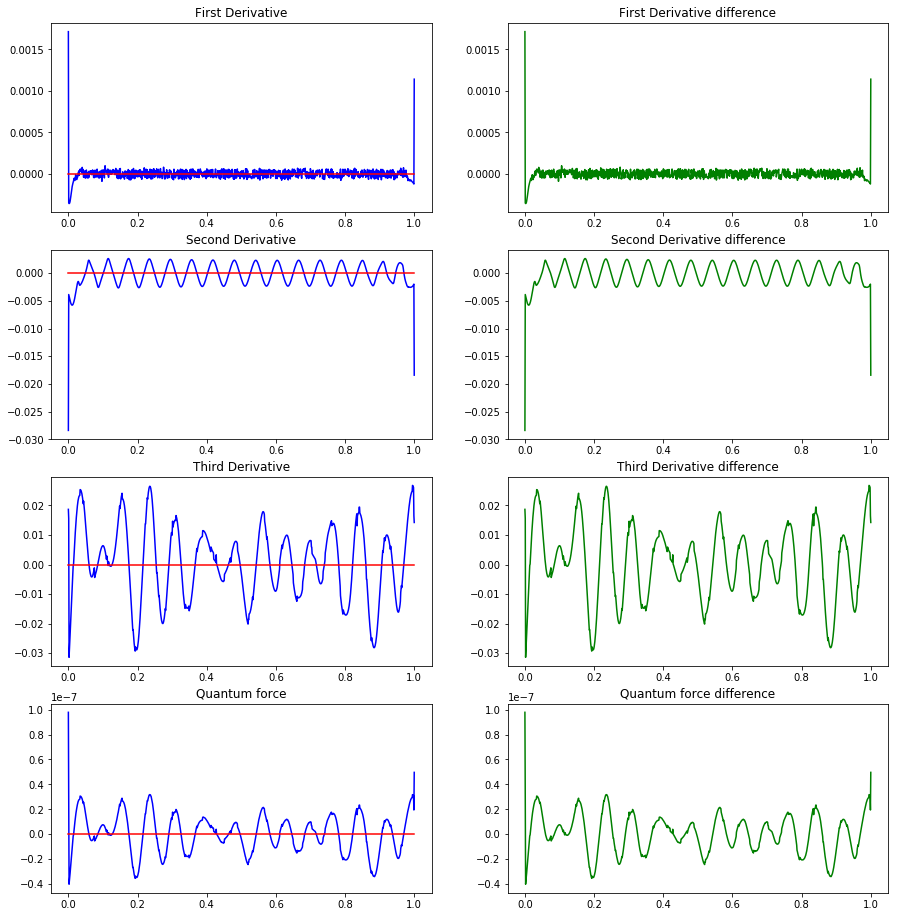

In [12]:
for epoch in range(0, 20_000+1):
    optimizer.zero_grad()
    values = torch.zeros([batch_size, 1000]).cuda()
    target = torch.zeros([batch_size, 3000]).cuda()
    output = torch.zeros([batch_size, 3000]).cuda()

    for i in range(batch_size):
        deg = np.random.randint(1, 101)
        func = FourierFunction(deg)
        values[i, :] = func.compute(X).cuda()
        target[i,:1000] = func.derive1(X)
        target[i,1000:2000] = func.derive2(X)
        target[i,2000:] = func.derive3(X)
        
    output = net(values)
 
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    if epoch % 1000 == 0:
        print("Epoch "+str(epoch)+": "+("%.6f" % loss.data.item()) + " Degree {}".format(deg))
        if use_gpu:
            data1 = output[batch_size-1, :1000].detach().cpu().numpy()
            bata1 = target[batch_size-1, :1000].detach().cpu().numpy()
            data2 = output[batch_size-1, 1000:2000].detach().cpu().numpy()
            bata2 = target[batch_size-1, 1000:2000].detach().cpu().numpy()
            data3 = output[batch_size-1, 2000:].detach().cpu().numpy()
            bata3 = target[batch_size-1, 2000:].detach().cpu().numpy()
            vals = values[batch_size-1, :].detach().cpu().numpy()
            pred_dqpot = vals*data1*data2 + 0.5*(vals**2)*data3
            true_dqpot = vals*bata1*bata2 + 0.5*(vals**2)*bata3
        
        plt.figure(figsize=(15, 16))
        plt.subplot(421)
        plt.plot(X.numpy(), data1, 'b')
        plt.plot(X.numpy(), bata1, 'r')
        plt.title('First Derivative')
        plt.subplot(422)
        plt.plot(X.numpy(), data1-bata1, 'g')
        plt.title('First Derivative difference')
        plt.subplot(423)
        plt.plot(X.numpy(), data2, 'b')
        plt.plot(X.numpy(), bata2, 'r')
        plt.title('Second Derivative')
        plt.subplot(424)
        plt.plot(X.numpy(), data2-bata2, 'g')
        plt.title('Second Derivative difference')
        plt.subplot(425)
        plt.plot(X.numpy(), data3, 'b')
        plt.plot(X.numpy(), bata3, 'r')
        plt.title('Third Derivative')
        plt.subplot(426)
        plt.plot(X.numpy(), data3-bata3, 'g')
        plt.title('Third Derivative difference')
        plt.subplot(427)
        plt.plot(X.numpy(), pred_dqpot, 'b')
        plt.plot(X.numpy(), true_dqpot, 'r')
        plt.title('Quantum force')
        plt.subplot(428)
        plt.plot(X.numpy(), pred_dqpot-true_dqpot, 'g')
        plt.title('Quantum force difference')
        plt.show()
    
    if epoch % 10000 == 0:
        torch.save(net.state_dict(), "saves/modela")